In [2]:
library(Seurat)
library(Signac)
library(SeuratWrappers)
library(SeuratObject)
library(repr)

library(chromVAR)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg19)



Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attac

### define ATAC color palette

In [3]:
# level.novaseq <- c('POD/PEC', 'PT', 'PT_VCAM1', 
#                    'tL1','tL2','tL-TAL', 'TAL1', 'TAL2/3',           
#                    'DCT', 'CNT', 
#                    'PC1', 'PC2', 
#                    'IC', 'Uro', 'ENDO', 'SMC',
#                    'Fib1', 'Fib2', 'Fib3', 
#                    'Ma', 'BT')

# palette.novaseq <- c('#00B5EB','#8DC71E', '#013220',
#                      '#936210', '#5E2A0F', '#C9F5E6', '#128394','#046494',
#                      '#be658d','#8a3e6a', 
#                      '#6a3070', '#4c2564',
#                      '#617A2E','#092092','#F9CC72', '#F8D1CD',
#                      '#E2062B', '#860111', '#B4041E',
#                      '#86DEBB', '#7D4729')

In [4]:
processed_dir = "../../processed_data/chromVAR"
dir.create(processed_dir, recursive = T, showWarnings = F)

### load wnn object

In [5]:
Sys.time()
load("../../processed_data/wnn/20221221_324701_cells_wnn.RData")
Sys.time()

[1] "2023-07-01 11:02:18 CDT"

[1] "2023-07-01 11:06:42 CDT"

In [6]:
novaseq = novaseq.wnn
novaseq

An object of class Seurat 
237522 features across 324701 samples within 2 assays 
Active assay: peaks (189184 features, 189184 variable features)
 1 other assay present: RNA
 6 dimensional reductions calculated: pca, harmony_RNA, lsi, harmony_peaks, umap.peaks, WNN.UMAP

In [7]:
ls()

[1] "level.novaseq"                    "level.novaseq.renal_region_new"  
[3] "level.novaseq.rna"                "novaseq"                         
[5] "novaseq.wnn"                      "palette.novaseq"                 
[7] "palette.novaseq.renal_region_new" "palette.novaseq.rna"             
[9] "processed_dir"

### update celltype_atac5 in novaseq

In [8]:
table(novaseq$celltype_atac5)


 POD/PEC       PT PT_VCAM1      tL1      tL2   tL-TAL     TAL1   TAL2/3 
    1766    93543    12319    25095     8878    20544    35720    18326 
     DCT      CNT      PC1      PC2       IC      Uro     ENDO      SMC 
   17704     9950    15729     3497    14133     3089    14049     4513 
    Fib1     Fib2     Fib3       Ma       BT 
    4668    10435      441     4136     6166 

In [9]:
# novaseq$celltype_atac5[(novaseq$celltype_atac5) == "Mes"][1:5]
# novaseq$celltype_atac5[(novaseq$celltype_atac5) == "DTL/ATL"] <- "tL-TAL"
# novaseq$celltype_atac5[(novaseq$celltype_atac5) == "CoD1"] <- "tL1"
# novaseq$celltype_atac5[(novaseq$celltype_atac5) == "CoD2/3"] <- "tL1"
# novaseq$celltype_atac5[(novaseq$celltype_atac5) == "CoD4"] <- "tL2"
# novaseq$celltype_atac5[(novaseq$celltype_atac5) == "Endo1"] <- "ENDO"
# novaseq$celltype_atac5[(novaseq$celltype_atac5) == "Endo2"] <- "ENDO"

In [10]:
# table(novaseq$celltype_atac5)

### add color palette info for atac

In [11]:
# novaseq$celltype_atac5 = as.character(novaseq$celltype_atac5)
# novaseq$celltype_atac5 <- factor(novaseq$celltype_atac5, levels = level.novaseq)

In [12]:
levels(novaseq$celltype_atac5)
class(novaseq$celltype_atac5)
table(novaseq$celltype_atac5)

[1] "POD/PEC"  "PT"       "PT_VCAM1" "tL1"      "tL2"      "tL-TAL"  
 [7] "TAL1"     "TAL2/3"   "DCT"      "CNT"      "PC1"      "PC2"     
[13] "IC"       "Uro"      "ENDO"     "SMC"      "Fib1"     "Fib2"    
[19] "Fib3"     "Ma"       "BT"

[1] "factor"


 POD/PEC       PT PT_VCAM1      tL1      tL2   tL-TAL     TAL1   TAL2/3 
    1766    93543    12319    25095     8878    20544    35720    18326 
     DCT      CNT      PC1      PC2       IC      Uro     ENDO      SMC 
   17704     9950    15729     3497    14133     3089    14049     4513 
    Fib1     Fib2     Fib3       Ma       BT 
    4668    10435      441     4136     6166 

### generate ATAC UMAP group.by celltype_atac5

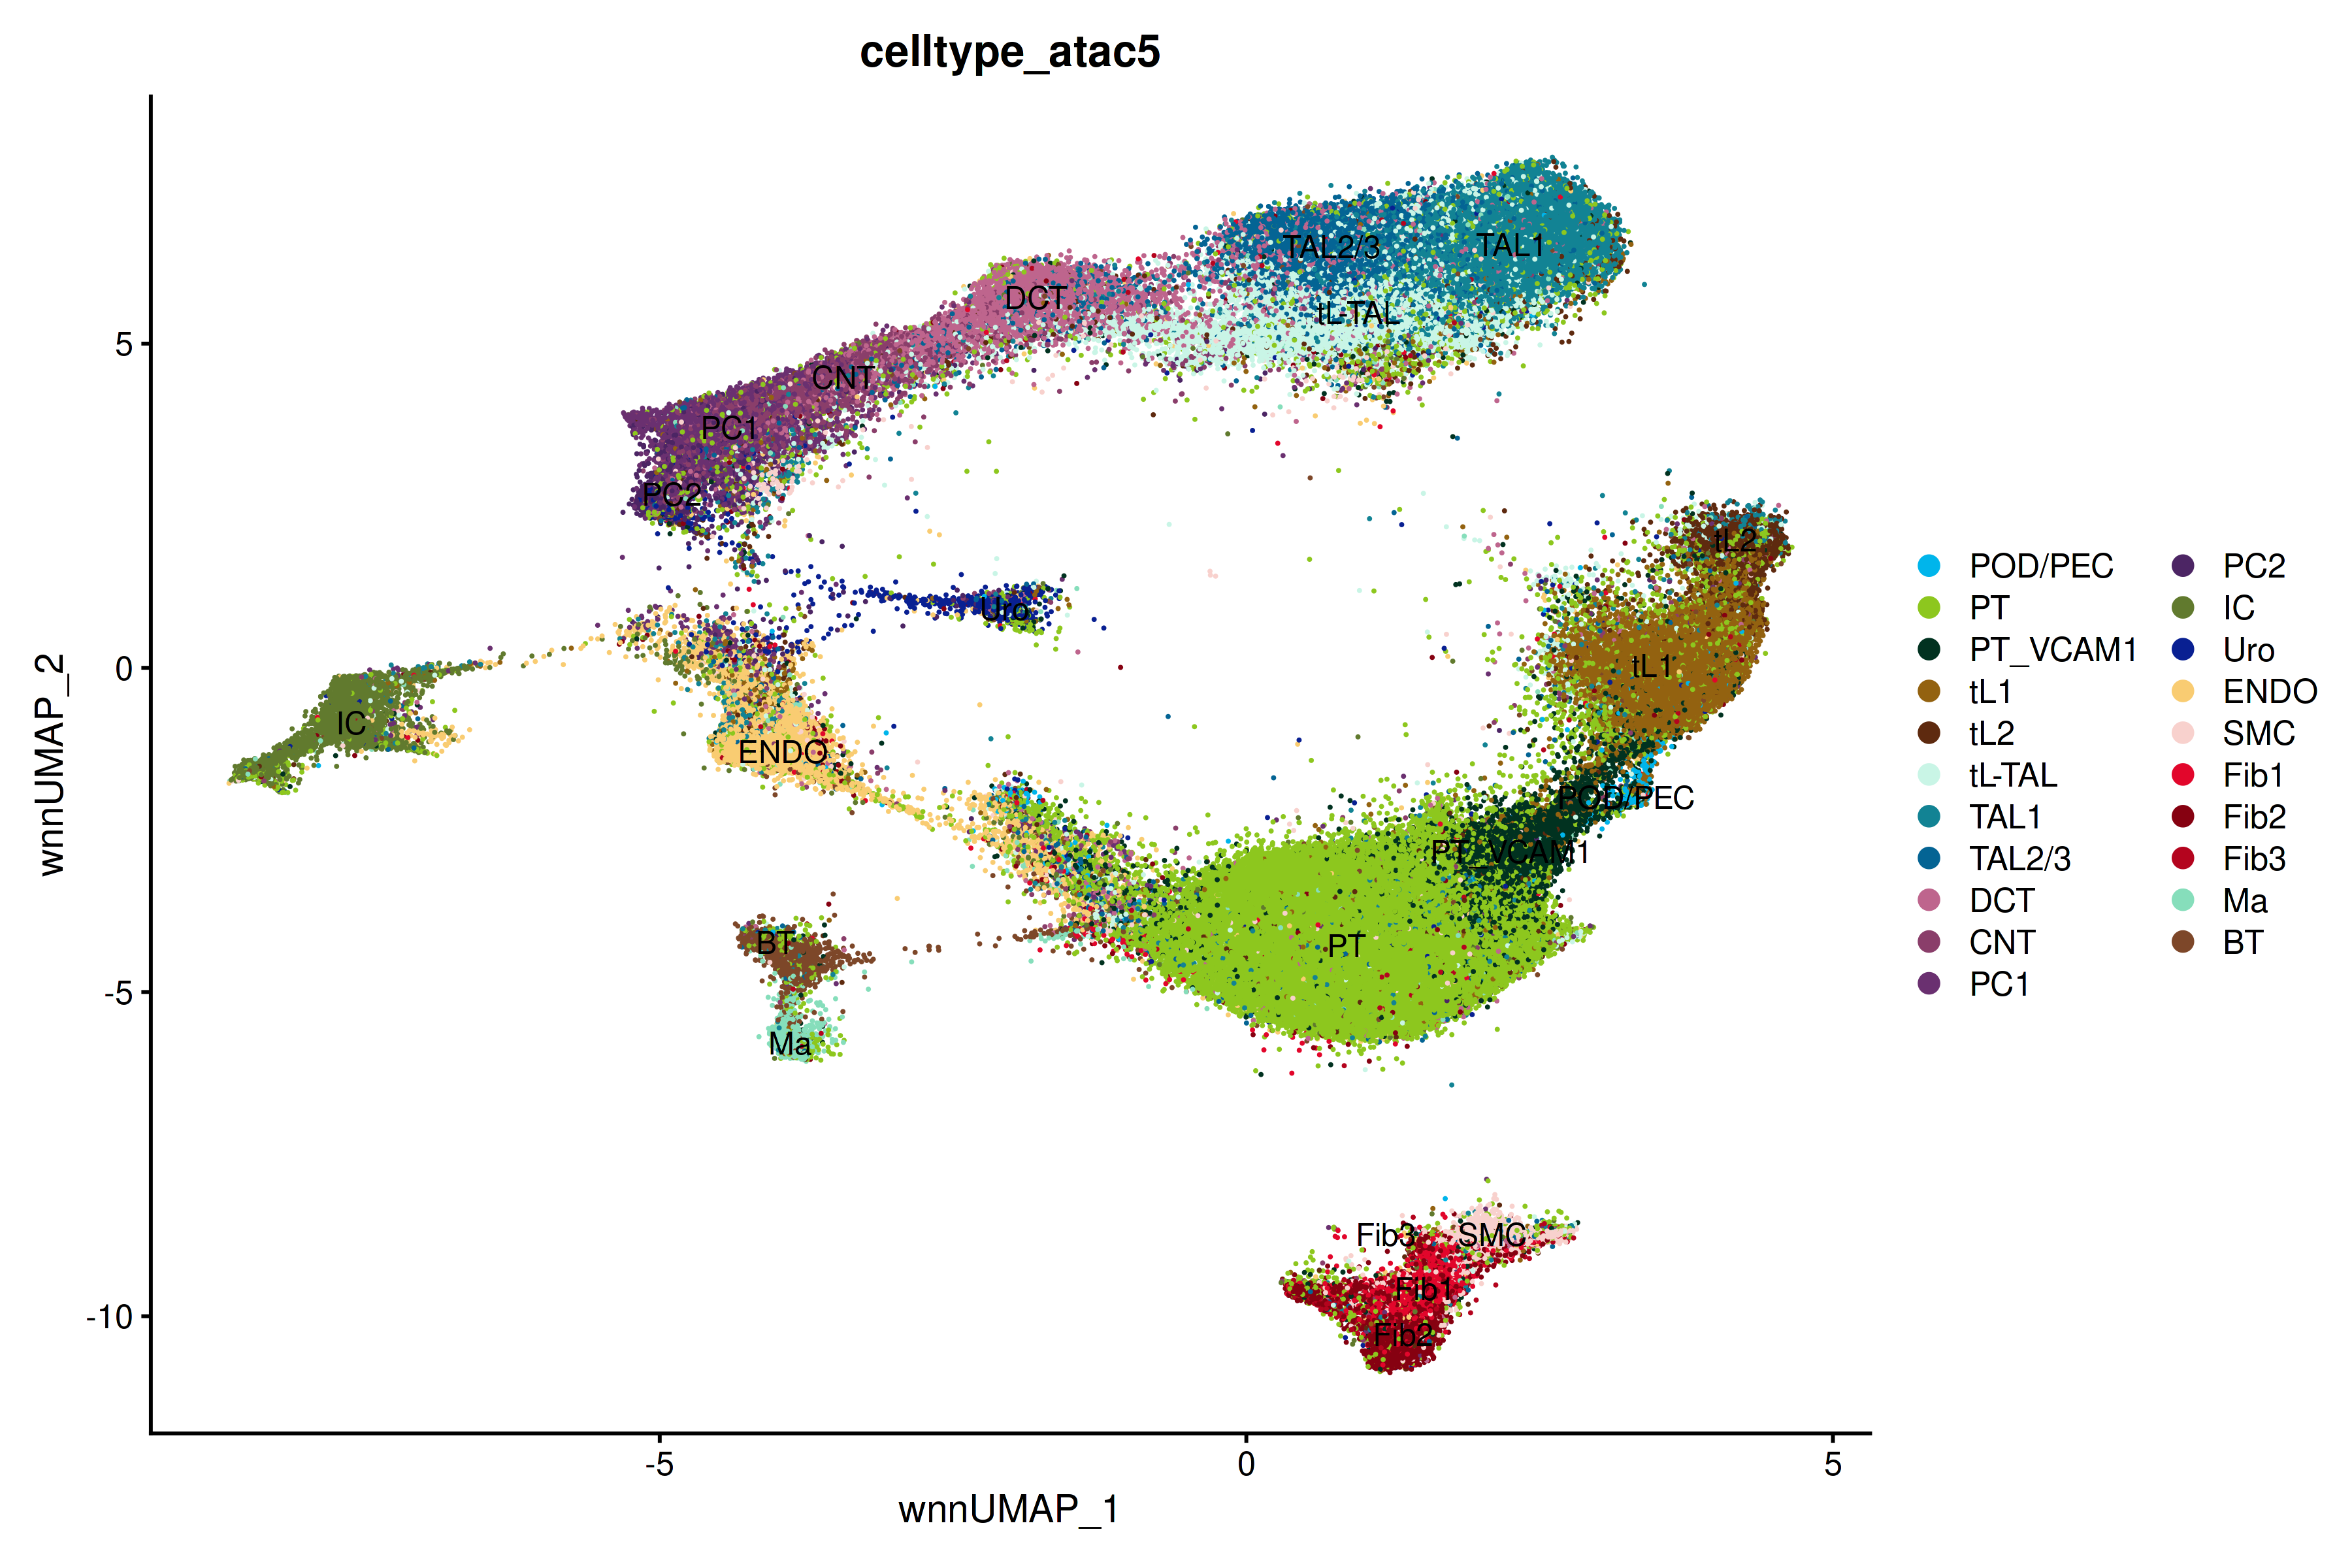

In [13]:
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 300)
DimPlot(novaseq, reduction = "WNN.UMAP", group.by = "celltype_atac5", raster = FALSE, cols = palette.novaseq, label = TRUE)

### start chromVAR analysis

### use celltype5_rna as Idents in consistent with RNA assay DEGs

In [14]:
set.seed(1234)

In [15]:
Idents(novaseq) <- "celltype5_rna"
head(Idents(novaseq))

R1.034,R2.082,R3.082,P1.76,B3 R1.047,R2.073,R3.003,P1.65,B2 
                          tL1                           PEC 
R1.025,R2.080,R3.017,P1.66,B2 R1.056,R2.038,R3.008,P1.48,B2 
                    PT_dediff                          TAL1 
R1.089,R2.082,R3.024,P1.14,B1 R1.031,R2.072,R3.075,P1.78,B3 
                          CNT                          TAL2 
29 Levels: JGA POD PEC PT PT_dediff PT_VCAM1 tL1 tL2 tL-TAL TAL1 TAL2 ... BT

In [16]:
Sys.time()
pwm_set <- getMatrixSet(x = JASPAR2020, opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)) #this is using the core vertebrate database
Sys.time()

[1] "2023-07-01 11:06:54 CDT"

[1] "2023-07-01 11:07:06 CDT"

In [17]:
length(pwm_set)

[1] 746

In [18]:
Sys.time()
novaseq <- AddMotifs(
  object = novaseq,
  genome = BSgenome.Hsapiens.UCSC.hg19,
  pfm = pwm_set,
  assay = "peaks"
)
Sys.time()

[1] "2023-07-01 11:07:06 CDT"

Building motif matrix

Finding motif positions

Creating Motif object



[1] "2023-07-01 11:11:20 CDT"

### Run chromVAR

In [19]:
Sys.time()
novaseq <- RunChromVAR(
  object = novaseq,
  genome = BSgenome.Hsapiens.UCSC.hg19
)
Sys.time()

[1] "2023-07-01 11:11:20 CDT"

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



[1] "2023-07-01 11:56:27 CDT"

### Identify differentially active motifs

In [20]:
DefaultAssay(novaseq) <- "chromvar"
novaseq

An object of class Seurat 
238268 features across 324701 samples within 3 assays 
Active assay: chromvar (746 features, 0 variable features)
 2 other assays present: peaks, RNA
 6 dimensional reductions calculated: pca, harmony_RNA, lsi, harmony_peaks, umap.peaks, WNN.UMAP

### Make a matrix with all the enriched motifs per celltype

In [21]:
Sys.time()
da_motifs <- FindAllMarkers(
  object = novaseq,
  only.pos = TRUE,
  test.use = 'LR',
  min.pct = 0.1,
  mean.fxn = rowMeans,
  fc.name = "avg_diff",
  logfc.threshold = 0 #find all cluster-specific motifs
)
Sys.time()

[1] "2023-07-01 11:56:28 CDT"

Calculating cluster JGA

Calculating cluster POD

Calculating cluster PEC

Calculating cluster PT

Calculating cluster PT_dediff

Calculating cluster PT_VCAM1

Calculating cluster tL1

Calculating cluster tL2

Calculating cluster tL-TAL

Calculating cluster TAL1

Calculating cluster TAL2

Calculating cluster TAL3

Calculating cluster DCT

Calculating cluster CNT

Calculating cluster PC1

Calculating cluster PC2

Calculating cluster ICA

Calculating cluster ICB

Calculating cluster Uro1

Calculating cluster Uro2

Calculating cluster ENDO

Calculating cluster SMC1

Calculating cluster SMC2

Calculating cluster SMC3

Calculating cluster Fib1

Calculating cluster Fib2

Calculating cluster Fib3

Calculating cluster Ma

Calculating cluster BT



[1] "2023-07-01 18:03:15 CDT"

In [22]:
da_motifs_raw = da_motifs

In [23]:
# Add motif name
DefaultAssay(novaseq) <- "peaks"
motif.names <- da_motifs$gene
da_motifs$gene <- ConvertMotifID(novaseq, id = motif.names)
da_motifs$motif <- motif.names 
colnames(da_motifs) <- c("motif.p_val","motif.avg_diff.","motif.pct.1","motif.pct.2","motif.p_val_adj","cluster","gene","motif")
dim(da_motifs)
head(da_motifs)

[1] 11363     8

,motif.p_val,motif.avg_diff.,motif.pct.1,motif.pct.2,motif.p_val_adj,cluster,gene,motif
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
MA0497.1,0.000000e+00,1.1415628,0.807,0.496,0.000000e+00,JGA,MEF2C,MA0497.1
MA0052.4,0.000000e+00,1.0785126,0.794,0.495,0.000000e+00,JGA,MEF2A,MA0052.4
MA0660.1,0.000000e+00,1.0401525,0.791,0.494,0.000000e+00,JGA,MEF2B,MA0660.1
MA0773.1,0.000000e+00,1.0044398,0.787,0.494,0.000000e+00,JGA,MEF2D,MA0773.1
MA1653.1,1.859992e-313,0.5411834,0.783,0.492,1.387554e-310,JGA,ZNF148,MA1653.1
MA0050.2,8.854866e-306,0.8571013,0.774,0.481,6.605730e-303,JGA,IRF1,MA0050.2


In [24]:
write.csv(da_motifs,file.path(processed_dir, "multiome_chromvar_DEmotif_minpct0.1_padj0.01.csv"))

In [25]:
chromvar_assay = novaseq@assays$chromvar
save(list = c("chromvar_assay", "da_motifs_raw", "da_motifs"),file = file.path(processed_dir, "multiome_chromvar_assay_and_DEmotif_minpct0.1_padj0.01.RData"), compress = T)

In [26]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] BSgenome.Hsapiens.UCSC.hg19_1.4.3 BSgenome_1.60.0                  
 [3] rtracklayer_1.52.0                Biostrings_2.60.0                
 [5] XVector_0.32.0                    GenomicRanges_1.44.0             
 [7] GenomeInfoDb_1.34.9 

In [27]:
Sys.time()

[1] "2023-07-01 18:04:49 CDT"